# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
!pip install --upgrade pip
!pip install imageio
!pip install scikit-image
!pip install matplotlib
# !pip install tensorflow
!pip install tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 49.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 61.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 41.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 56.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 61.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 61.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 63.3 MB/s eta 0:00:00a 0:00:01
   ━━

In [2]:
import numpy as np
import os
import imageio
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import  Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

2024-10-05 02:43:07.431664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 02:43:07.453117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 02:43:07.459631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 02:43:07.476579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 02:43:08.344598: W tensorflow/compiler/tf2

In [3]:
import sys; print(sys.version)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [4]:
print(tf.__version__)
print(keras.__version__)

2.17.0
3.6.0


In [5]:
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

NUM_CLASSES = 5
NUM_FRAMES = 30
IMG_HEIGHT = 120
IMG_WIDTH = 120
NUM_CHANNELS = 3

#parameter which will be used for model training
num_images = 30
batch_size = 64 #experiment with the batch size
sample_frames = 30
num_epochs = 20

print(f'Train length: {len(train_doc)}')
print(f'Validation length: {len(val_doc)}')

Train length: 663
Validation length: 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def prepare_image(image, channel, height, width):
  image = resize(image, (height, width), anti_aliasing=True)
  image = (image[...,channel])/255
  return image

In [9]:
def generate_image(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, height=120, width=120, augment=False):
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            batch_data[folder,idx,:,:,0] = prepare_image(image, 0, height, width)
            batch_data[folder,idx,:,:,1] = prepare_image(image, 1, height, width)
            batch_data[folder,idx,:,:,2] = prepare_image(image, 2, height, width)                 
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [10]:
def generator(source_path, folder_list, batch_size):
    img_idx = np.round(np.linspace(0,NUM_FRAMES-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, NUM_CLASSES)) # batch_labels is the one hot representation of the output           

            yield generate_image(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, IMG_HEIGHT, IMG_WIDTH)
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size, NUM_CLASSES)) # batch_labels is the one hot representation of the output           

            yield generate_image(t, source_path, remaining_batch_size, img_idx, num_batches, batch_data, batch_labels, IMG_HEIGHT, IMG_WIDTH)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/workspace/Project_data/train'
val_path = '/workspace/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


#### Validating the Generator

In [12]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

(64, 30, 120, 120, 3)
(64, 30, 120, 120, 3)


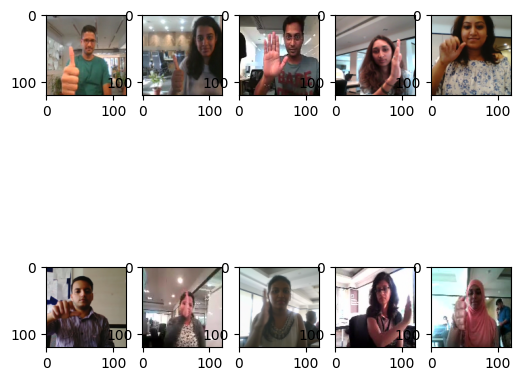

In [13]:
fig, ax = plt.subplots(2,5, figsize=(6,6))
ax[0,0].imshow(sample_batch_data[3,10,:,:,:])   
ax[0,1].imshow(sample_batch_data[6,10,:,:,:])
ax[0,2].imshow(sample_batch_data[9,15,:,:,:])   
ax[0,3].imshow(sample_batch_data[15,6,:,:,:])
ax[0,4].imshow(sample_batch_data[22,7,:,:,:])

ax[1,0].imshow(sample_val_batch_data[3,10,:,:,:])   
ax[1,1].imshow(sample_val_batch_data[6,10,:,:,:])
ax[1,2].imshow(sample_val_batch_data[9,15,:,:,:])   
ax[1,3].imshow(sample_val_batch_data[15,6,:,:,:])
ax[1,4].imshow(sample_val_batch_data[22,7,:,:,:])
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Model callback utility

In [14]:
def plot_history(history):
  # """
  #   Plotting training and validation learning curves.

  #   Args:
  #     history: model history with all the metric measures
  # """
  # fig, (ax1, ax2) = plt.subplots(2)
  # fig.set_size_inches(12, 6)

  # # Plot loss
  # ax1.set_title('Loss')
  # ax1.plot(history.history['loss'], label = 'train')
  # ax1.plot(history.history['val_loss'], label = 'test')
  # ax1.set_ylabel('Loss')

  # # Determine upper bound of y-axis
  # max_loss = max(history.history['loss'] + history.history['val_loss'])

  # ax1.set_ylim([0, np.ceil(max_loss)])
  # ax1.set_xlabel('Epoch')
  # ax1.legend(['Train', 'Validation']) 

  # # Plot accuracy
  # ax2.set_title('Accuracy')
  # ax2.plot(history.history['categorical_accuracy'],  label = 'train')
  # ax2.plot(history.history['val_categorical_accuracy'], label = 'test')
  # ax2.set_ylabel('Accuracy')
  # ax2.set_ylim([0, 1])
  # ax2.set_xlabel('Epoch')
  # ax2.legend(['Train', 'Validation'])

  # plt.show()
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    ax = ax.ravel()
    
    for i, metric in enumerate(["categorical_accuracy", "loss"]):
        ax[i].plot(model.history.history[metric])
        ax[i].plot(model.history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

In [71]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'best_model_weightdetails.weights.keras'
    # Define the ModelCheckpoint callback
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                          save_best_only=True,
                                          monitor='val_loss',
                                          save_weights_only=False,
                                          mode='auto')
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

In [16]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [17]:
# Common utility to create conv 3D models
def create_3d_cnn_model(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25):

    model = Sequential()
    
    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(sample_frames,IMG_HEIGHT,IMG_WIDTH,NUM_CHANNELS)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0], activation='relu'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1],activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(NUM_CLASSES, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

### In this code two types of types of architectures are explored.
1) Conv 3D Model
2) Standard CNN + RNN

#### Model 1: 
Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [25]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 64  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 30
print ('# num_frames per video =', sample_frames)
model = create_3d_cnn_model((16, 32, 64, 128), (256,128), 0.25)

print (model.summary())

# epochs = 20
# batch size = 64
# num_frames per video = 30


2024-10-02 11:45:51.517434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_1 (Conv3D)               │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 15, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 7, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 3, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch1_conv3D_1")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [30]:
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1,        
                    callbacks=callbacks_list, 
                    validation_data=val_generator,          
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Epoch 1/20


I0000 00:00:1727870033.332068    1198 service.cc:146] XLA service 0x70521c018e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727870033.332137    1198 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-02 11:53:53.648515: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-02 11:53:54.055977: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/11 ━━━━━━━━━━━━━━━━━━━━ 2:07 13s/step - categorical_accuracy: 0.2656 - loss: 2.2316

I0000 00:00:1727870043.125239    1198 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - categorical_accuracy: 0.4181 - loss: 1.7546 
Epoch 1: val_loss improved from inf to 1.71735, saving model to model_arch1_conv3D_1_2024-10-0211_40_05.031277/best_model_weightdetails.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 261s 25s/step - categorical_accuracy: 0.4259 - loss: 1.7318 - val_categorical_accuracy: 0.3400 - val_loss: 1.7174 - learning_rate: 0.0010
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - categorical_accuracy: 0.7229 - loss: 0.7546 
Epoch 2: val_loss did not improve from 1.71735
11/11 ━━━━━━━━━━━━━━━━━━━━ 210s 21s/step - categorical_accuracy: 0.7244 - loss: 0.7521 - val_categorical_accuracy: 0.2000 - val_loss: 2.6357 - learning_rate: 0.0010
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - categorical_accuracy: 0.8372 - loss: 0.4909 
Epoch 3: val_loss did not improve from 1.71735
11/11 ━━━━━━━━━━━━━━━━━━━━ 226s 22s/step - categorical_accuracy: 0.8373 - loss: 0.4890 - val_categorical_accuracy: 0.2500 - val_loss: 3.8120 - learni

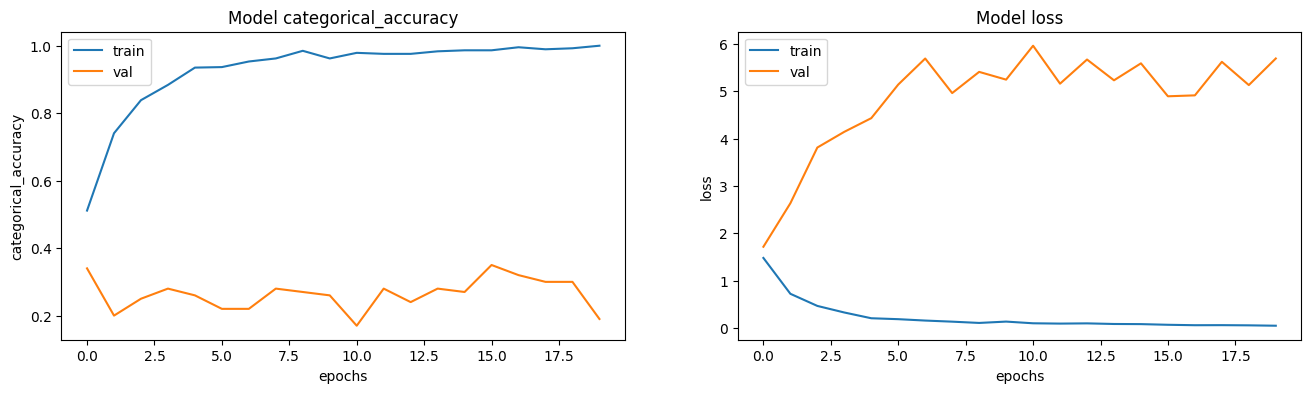

In [42]:
plot_history(history)

#### Observation :: The perfect accuracy on training data(1.00) with  poor validation accuracy(0.1900) and high validation loss suggests overfitting

#### Model 2: 
Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)¶

In [43]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 32  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
model = create_3d_cnn_model((16, 32, 64, 128), (256,128), 0.25)

print (model.summary())

# epochs = 20
# batch size = 32
# num_frames per video = 20


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_5 (Conv3D)               │ (None, 20, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 20, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 10, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 10, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 10, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 5, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 5, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 5, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch1_conv3D_2")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [45]:
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1,        
                    callbacks=callbacks_list, 
                    validation_data=val_generator,          
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.4051 - loss: 1.8528 
Epoch 1: val_loss improved from inf to 2.15873, saving model to model_arch1_conv3D_2_2024-10-0211_40_05.031277/best_model_weightdetails.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 281s 14s/step - categorical_accuracy: 0.4091 - loss: 1.8393 - val_categorical_accuracy: 0.2300 - val_loss: 2.1587 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.6874 - loss: 0.8440 
Epoch 2: val_loss did not improve from 2.15873
21/21 ━━━━━━━━━━━━━━━━━━━━ 231s 12s/step - categorical_accuracy: 0.6885 - loss: 0.8420 - val_categorical_accuracy: 0.2100 - val_loss: 3.4002 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.8491 - loss: 0.4354 
Epoch 3: val_loss did not improve from 2.15873
21/21 ━━━━━━━━━━━━━━━━━━━━ 224s 11s/step - categorical_accuracy: 0.8488 - loss: 0.4362 - val_categorical_accuracy: 0.2200 - val_loss: 4.99

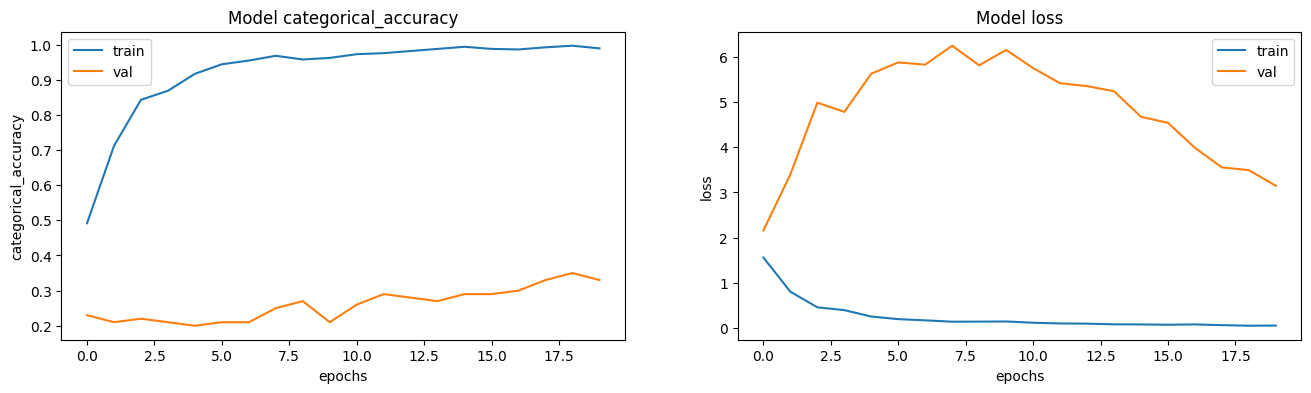

In [46]:
plot_history(history)

#### Observation :: The gap between the training accuracy (99.12%) and validation accuracy (33%) suggests the model might still be overfitting to the training data

#### Model 3: 
Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)¶

In [49]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 8  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
model = create_3d_cnn_model((16, 32, 64, 128), (256,128), 0.25)

print (model.summary())

# epochs = 20
# batch size = 8
# num_frames per video = 20


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_9 (Conv3D)               │ (None, 20, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 20, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 20, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 10, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 10, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 10, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 5, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 5, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 5, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_12 (Conv3D)              │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch1_conv3D_3")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [51]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3459 - loss: 1.9531
Epoch 1: val_loss improved from inf to 6.62579, saving model to model_arch1_conv3D_3_2024-10-0211_40_05.031277/best_model_weightdetails.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - categorical_accuracy: 0.3466 - loss: 1.9496 - val_categorical_accuracy: 0.1700 - val_loss: 6.6258 - learning_rate: 0.0010
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5926 - loss: 1.1270
Epoch 2: val_loss improved from 6.62579 to 5.89779, saving model to model_arch1_conv3D_3_2024-10-0211_40_05.031277/best_model_weightdetails.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - categorical_accuracy: 0.5922 - loss: 1.1274 - val_categorical_accuracy: 0.1900 - val_loss: 5.8978 - learning_rate: 0.0010
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5852 - loss: 1.1494
Epoch 3: val_loss did not improve from 5.89779
83/83 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - 

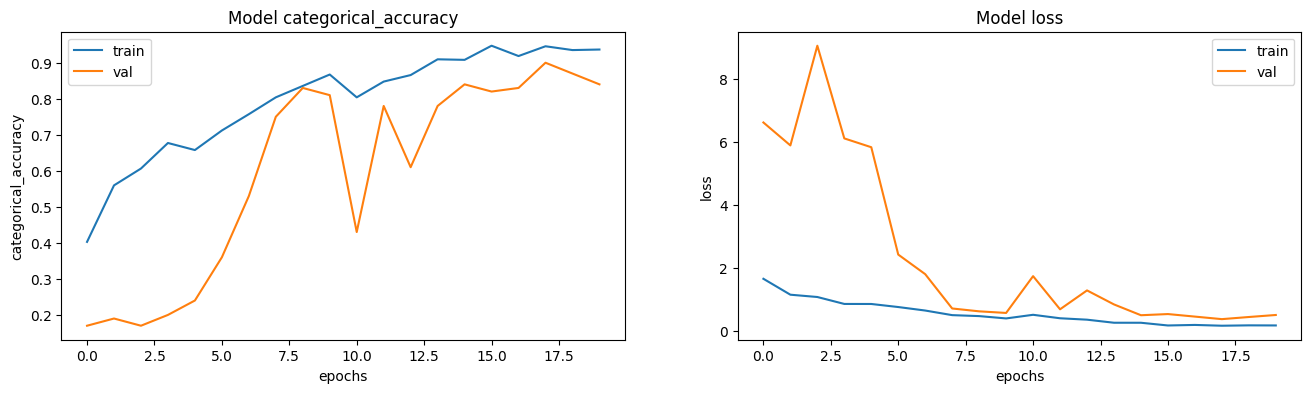

In [52]:
plot_history(history)

#### Observation :: This model shows significant improvement in both training and validation performance

#### Model 4: 
Conv 3D Model with 20 frames per video (32, 64, 128, 256 filters conv 3D layers + 256 dense layer + 256 dense layer + image size 120 by 120)¶

In [19]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 16  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
model = create_3d_cnn_model((32, 64, 128, 256), (256,256), 0.50)

print (model.summary())

# epochs = 20
# batch size = 16
# num_frames per video = 20


2024-10-03 01:57:23.850698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 20, 120, 120,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 20, 120, 120,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 120, 120,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 60, 60, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10, 60, 60, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 60, 60, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 30, 30, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 5, 30, 30, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 30, 30, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 15, 15, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2, 15, 15, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 15, 15, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,446,853 (16.96 MB)

 Trainable params: 4,444,869 (16.96 MB)

 Non-trainable params: 1,984 (7.75 KB)

None


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch1_conv3D_4")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [21]:
tf.debugging.set_log_device_placement(True)

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20


I0000 00:00:1727920735.187203     847 service.cc:146] XLA service 0x751e200182e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727920735.187261     847 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-03 01:58:55.316516: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 01:58:55.708726: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 2/42 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - categorical_accuracy: 0.2031 - loss: 2.9578 

I0000 00:00:1727920743.354498     847 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2918 - loss: 2.5108
Epoch 1: val_loss improved from inf to 3.47902, saving model to model_arch1_conv3D_4_2024-10-0301_52_24.002201/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 284s 7s/step - categorical_accuracy: 0.2939 - loss: 2.5011 - val_categorical_accuracy: 0.2400 - val_loss: 3.4790 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.4626 - loss: 1.5775
Epoch 2: val_loss did not improve from 3.47902
42/42 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - categorical_accuracy: 0.4631 - loss: 1.5760 - val_categorical_accuracy: 0.2100 - val_loss: 3.5213 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5980 - loss: 1.1987
Epoch 3: val_loss improved from 3.47902 to 3.28945, saving model to model_arch1_conv3D_4_2024-10-0301_52_24.002201/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 230s 6s/step - categorical

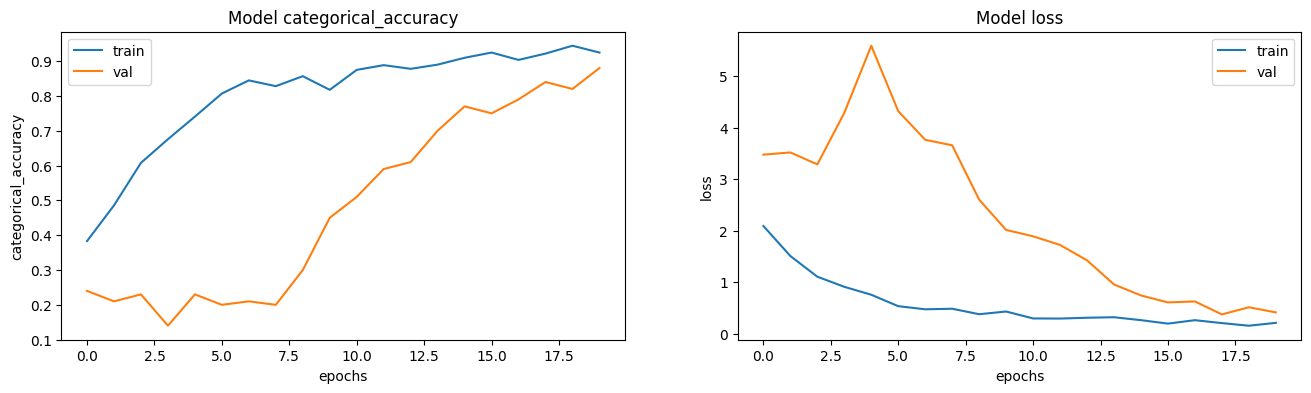

In [23]:
plot_history(history)

#### Observation :: The gap between the training accuracy (91.91%) and validation accuracy (88%) is small, which suggests that the model has found a good balance between learning from the training data and generalizing to new data

#### Model 5: 
Using second architecture, ie, CNN + RNN concept, further set of models are getting built.¶

In [19]:
# Common utility to create cnn + rnn based models
def create_3d_cnn_rnn_model(conv_filters=(16, 32, 64, 128, 256), dense_nodes=(256,128), dropout=0.25, islstm = 1, cells=64):
    model = Sequential()

    model.add(TimeDistributed(Conv2D(conv_filters[0], (3, 3), padding='same', activation='relu'),
    input_shape=(sample_frames,IMG_HEIGHT,IMG_WIDTH,NUM_CHANNELS)))
    
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(conv_filters[1], (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(conv_filters[2], (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(conv_filters[3], (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(conv_filters[4], (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))


    if islstm == 1:
        model.add(LSTM(cells))
    else:
        model.add(GRU(cells))
        
    model.add(Dense(dense_nodes[0], activation='relu'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1],activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(NUM_CLASSES, activation='softmax'))
    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

In [38]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 64  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 30
print ('# num_frames per video =', sample_frames)
model = create_3d_cnn_rnn_model((16, 32, 64, 128, 256), (256,128), 0.25, 1, 64)

print (model.summary())

# epochs = 20
# batch size = 64
# num_frames per video = 30


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_16             │ (None, 30, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 30, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 30, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 30, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 30, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 30, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 30, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 30, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 30, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 30, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 30, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 30, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 30, 7, 7, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 30, 7, 7, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 30, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 30, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │       606,46

 Total params: 1,052,773 (4.02 MB)

 Trainable params: 1,051,013 (4.01 MB)

 Non-trainable params: 1,760 (6.88 KB)

None


In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch2_cnn_rnn_1")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [40]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20


W0000 00:00:1728050832.887262    1409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728050832.946951    1409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728050832.998215    1409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728050832.998693    1409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728050832.999181    1409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728050832.999777    1409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728050833.000406    1409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728050833.000916    1409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728050833.001380    1409 gp

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_4_1/time_distributed_24_1/strided_slice_20/StridedSliceGrad defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 737, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_382/909929702.py", line 2, in <module>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 70, in train_step

OOM when allocating tensor with shape[30,64,30,30,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_4_1/time_distributed_24_1/strided_slice_20/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_57076]

#### Observation :: OOM Error got triggered as GPU is running out of memory.

In [41]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 16  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 30
print ('# num_frames per video =', sample_frames)
model = create_3d_cnn_rnn_model((16, 32, 64, 128, 256), (256,128), 0.25, 1, 64)

print (model.summary())

# epochs = 20
# batch size = 16
# num_frames per video = 30


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_32             │ (None, 30, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 30, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 30, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 30, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_36             │ (None, 30, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 30, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 30, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 30, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 30, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 30, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_42             │ (None, 30, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ (None, 30, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_44             │ (None, 30, 7, 7, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_45             │ (None, 30, 7, 7, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_46             │ (None, 30, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_47             │ (None, 30, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │       606,46

 Total params: 1,052,773 (4.02 MB)

 Trainable params: 1,051,013 (4.01 MB)

 Non-trainable params: 1,760 (6.88 KB)

None


In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch2_cnn_rnn_2")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [23]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [48]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3778 - loss: 1.6113

W0000 00:00:1728052371.556591    1377 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728052371.557008    1377 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728052371.557289    1377 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728052371.557592    1377 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728052371.557960    1377 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728052371.558238    1377 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728052371.558519    1377 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728052371.558827    1377 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728052371.559155    1377 gp


Epoch 1: val_loss improved from inf to 1.35103, saving model to model_arch2_cnn_rnn_2_2024-10-0412_38_35.108461/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 266s 6s/step - categorical_accuracy: 0.3787 - loss: 1.6091 - val_categorical_accuracy: 0.4000 - val_loss: 1.3510 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5383 - loss: 1.2076
Epoch 2: val_loss improved from 1.35103 to 1.23094, saving model to model_arch2_cnn_rnn_2_2024-10-0412_38_35.108461/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 256s 6s/step - categorical_accuracy: 0.5385 - loss: 1.2083 - val_categorical_accuracy: 0.5100 - val_loss: 1.2309 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5512 - loss: 1.2122
Epoch 3: val_loss improved from 1.23094 to 1.13428, saving model to model_arch2_cnn_rnn_2_2024-10-0412_38_35.108461/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 23

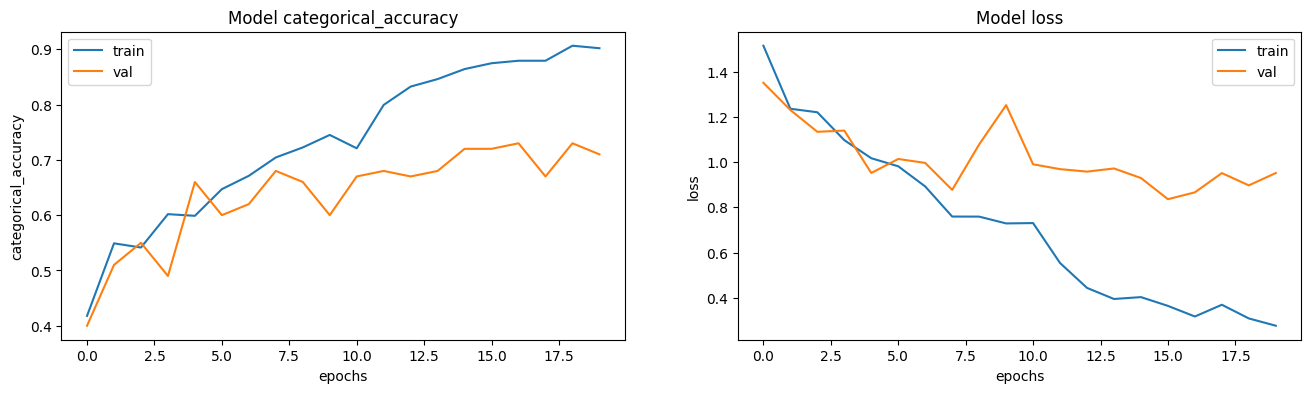

In [49]:
plot_history(history)

#### Observation :: The training accuracy is significantly higher than the validation accuracy, and the validation loss is much higher than the training loss. This suggests potential overfitting.

In [50]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 16  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
model = create_3d_cnn_rnn_model((16, 32, 64, 128, 256), (256,128), 0.50, 1, 64)

print (model.summary())

# epochs = 20
# batch size = 16
# num_frames per video = 20


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_48             │ (None, 20, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_49             │ (None, 20, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_50             │ (None, 20, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_51             │ (None, 20, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_52             │ (None, 20, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_53             │ (None, 20, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_54             │ (None, 20, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_55             │ (None, 20, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_56             │ (None, 20, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_57             │ (None, 20, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_58             │ (None, 20, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_59             │ (None, 20, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_60             │ (None, 20, 7, 7, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_61             │ (None, 20, 7, 7, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_62             │ (None, 20, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_63             │ (None, 20, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │       606,46

 Total params: 1,052,773 (4.02 MB)

 Trainable params: 1,051,013 (4.01 MB)

 Non-trainable params: 1,760 (6.88 KB)

None


In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch2_cnn_rnn_3")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [52]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2949 - loss: 2.3112
Epoch 1: val_loss improved from inf to 1.50214, saving model to model_arch2_cnn_rnn_3_2024-10-0412_38_35.108461/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 309s 7s/step - categorical_accuracy: 0.2956 - loss: 2.3073 - val_categorical_accuracy: 0.3300 - val_loss: 1.5021 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3205 - loss: 2.0229
Epoch 2: val_loss improved from 1.50214 to 1.43067, saving model to model_arch2_cnn_rnn_3_2024-10-0412_38_35.108461/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 258s 6s/step - categorical_accuracy: 0.3215 - loss: 2.0203 - val_categorical_accuracy: 0.3700 - val_loss: 1.4307 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.4163 - loss: 1.7710
Epoch 3: val_loss improved from 1.43067 to 1.32895, saving model to model_arch2_cnn_rnn

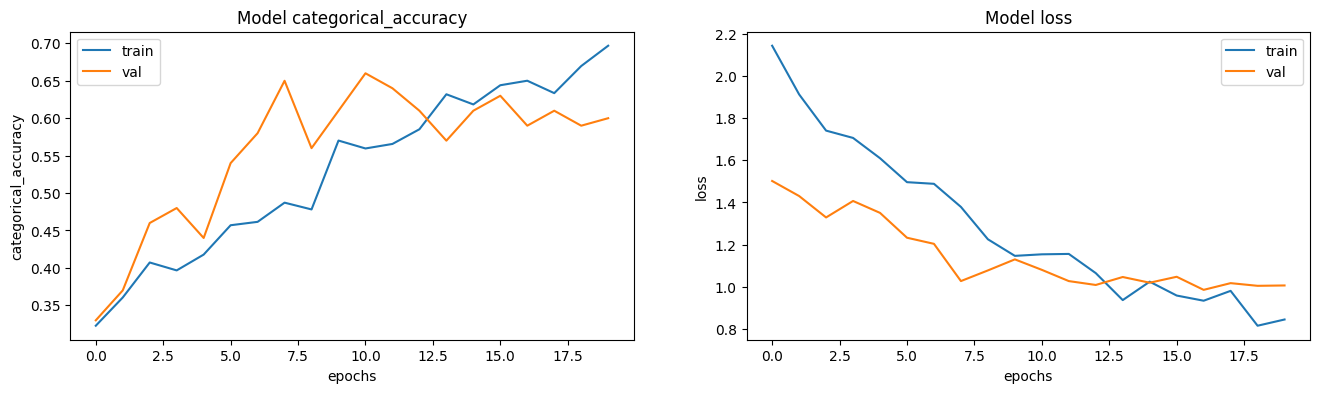

In [53]:
plot_history(history)

#### Observation :: The model is underfitting here, meaning it’s not even performing well on the training data.

In [20]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 16  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
# GRU
model = create_3d_cnn_rnn_model((16, 32, 64, 128, 256), (256,128), 0.50, 0, 64) 
print (model.summary())

# epochs = 20
# batch size = 16
# num_frames per video = 20


2024-10-05 02:45:53.648300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:46:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 7, 7, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 7, 7, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 20, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │       455,04

 Total params: 901,349 (3.44 MB)

 Trainable params: 899,589 (3.43 MB)

 Non-trainable params: 1,760 (6.88 KB)

None


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch2_cnn_rnn_4")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3915 - loss: 1.8285
Epoch 1: val_loss improved from 1.46425 to 1.29286, saving model to model_arch2_cnn_rnn_4_2024-10-0502_43_29.386650/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 265s 6s/step - categorical_accuracy: 0.3917 - loss: 1.8275 - val_categorical_accuracy: 0.4800 - val_loss: 1.2929 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.4095 - loss: 1.7651
Epoch 2: val_loss improved from 1.29286 to 1.12512, saving model to model_arch2_cnn_rnn_4_2024-10-0502_43_29.386650/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 258s 6s/step - categorical_accuracy: 0.4103 - loss: 1.7621 - val_categorical_accuracy: 0.5300 - val_loss: 1.1251 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.4595 - loss: 1.5554
Epoch 3: val_loss did not improve from 1.12512
42/42 ━━━━━━━━━━━━━━━━━━━━ 228s 6s/s

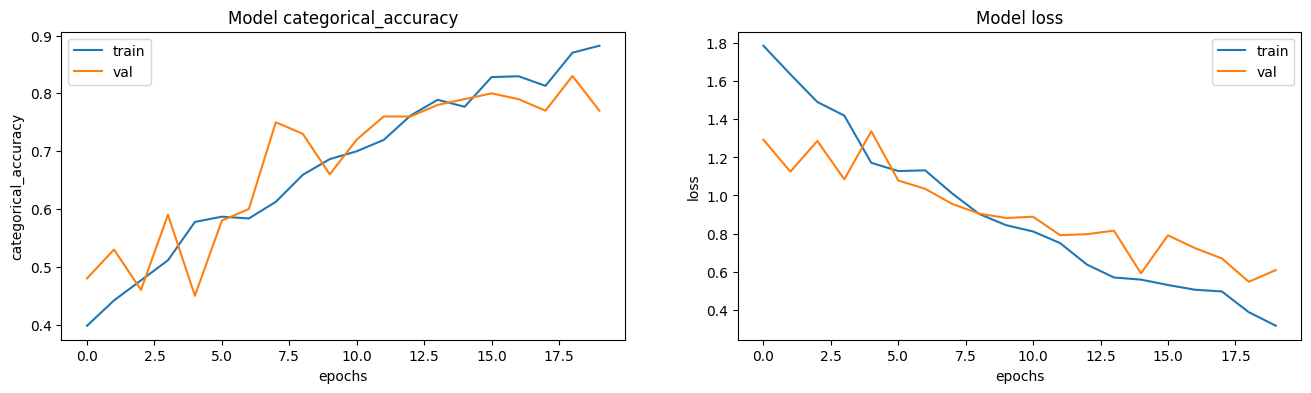

In [25]:
plot_history(history)

#### Observation :: The model is performing well on the training data (88.51% accuracy) but is not generalizing as well on the validation data (77% accuracy).

In [26]:
from keras.applications import mobilenet

In [37]:
# Common utility to create cnn + rnn + transfer learning based models
def create_cnn_rnn_transferlearning_model(dense_nodes=256, dropout=0.25, islstm = 1, transfer_train=False):
    cells=64
    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(sample_frames,IMG_HEIGHT,IMG_WIDTH,NUM_CHANNELS)))
    
    for layer in model.layers:
        layer.trainable = transfer_train
            
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    
    if islstm == 1:
        model.add(LSTM(cells))
    else:
        model.add(GRU(cells))
        
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])  
    
    return model

In [38]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 16  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
# LTSM
model = create_cnn_rnn_transferlearning_model(dense_nodes=256, dropout=0.25, islstm = 1, transfer_train=False) 
print (model.summary())

# epochs = 20
# batch size = 16
# num_frames per video = 20


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_20             │ (None, 20, 3, 3, 1024) │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 20, 3, 3, 1024) │         4,096 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 20, 1, 1, 1024) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 20, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │       278,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,529,669 (13.46 MB)

 Trainable params: 298,757 (1.14 MB)

 Non-trainable params: 3,230,912 (12.32 MB)

None


In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch2_cnn_rnn_trslrn_1")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [40]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20
 1/42 ━━━━━━━━━━━━━━━━━━━━ 32:06 47s/step - categorical_accuracy: 0.1250 - loss: 1.6188

W0000 00:00:1728103574.011804     706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103574.012217     706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103574.012492     706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103574.012735     706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103574.012972     706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103574.013207     706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103574.013512     706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103574.013764     706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103574.014061     706 gp

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2752 - loss: 1.5539

W0000 00:00:1728103799.416625     663 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103799.416984     663 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103799.417240     663 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103799.417528     663 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103799.417813     663 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103799.418056     663 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103799.418358     663 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103799.418600     663 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103799.418893     663 gp


Epoch 1: val_loss improved from inf to 1.17507, saving model to model_arch2_cnn_rnn_trslrn_1_2024-10-0502_43_29.386650/best_model_weightdetails.weights.h5


W0000 00:00:1728103849.046420     658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103849.046784     658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103849.047029     658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103849.047273     658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103849.047565     658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103849.047836     658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103849.048084     658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103849.048389     658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728103849.048680     658 gp

42/42 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step - categorical_accuracy: 0.2773 - loss: 1.5519 - val_categorical_accuracy: 0.5700 - val_loss: 1.1751 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.6598 - loss: 0.9791
Epoch 2: val_loss improved from 1.17507 to 0.88104, saving model to model_arch2_cnn_rnn_trslrn_1_2024-10-0502_43_29.386650/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 256s 6s/step - categorical_accuracy: 0.6599 - loss: 0.9777 - val_categorical_accuracy: 0.6700 - val_loss: 0.8810 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.7979 - loss: 0.6174
Epoch 3: val_loss improved from 0.88104 to 0.77125, saving model to model_arch2_cnn_rnn_trslrn_1_2024-10-0502_43_29.386650/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 227s 6s/step - categorical_accuracy: 0.7979 - loss: 0.6166 - val_categorical_accuracy: 0.7200 - val_loss: 0.7712 - learning_rate: 0.0010


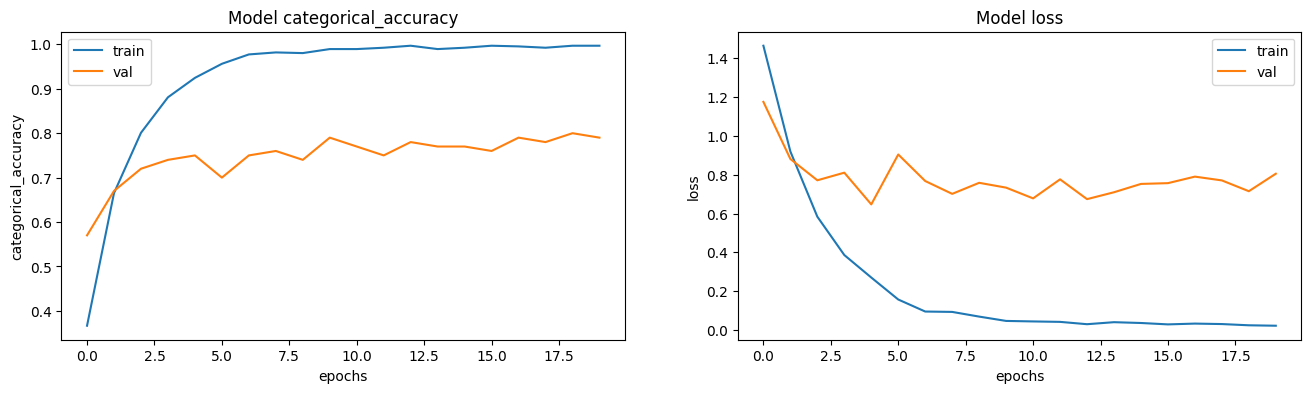

In [41]:
plot_history(history)

#### Observation :: The model is performing very well on the training set with a 99.91% accuracy, and with validation accuracy is 79.00%, which suggests that the model is performing worse on the validation set compared to the training set. This might indicate some overfitting,

In [42]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 16  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
# LTSM
model = create_cnn_rnn_transferlearning_model(dense_nodes=256, dropout=0.25, islstm = 1, transfer_train=True) 
print (model.summary())

# epochs = 20
# batch size = 16
# num_frames per video = 20


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_24             │ (None, 20, 3, 3, 1024) │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 20, 3, 3, 1024) │         4,096 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 20, 1, 1, 1024) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 20, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │       278,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,529,669 (13.46 MB)

 Trainable params: 3,505,733 (13.37 MB)

 Non-trainable params: 23,936 (93.50 KB)

None


In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch2_cnn_rnn_trslrn_2")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [44]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20


W0000 00:00:1728108655.425924     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108655.426384     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108655.426662     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108655.427007     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108655.427268     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108655.427519     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108655.427765     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108655.428021     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108655.428270     703 gp

 1/42 ━━━━━━━━━━━━━━━━━━━━ 1:31:11 133s/step - categorical_accuracy: 0.1875 - loss: 1.7448

W0000 00:00:1728108656.076571     674 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108656.076766     674 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108656.076965     674 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108656.077158     674 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108656.077356     674 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108656.077557     674 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108656.077792     674 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108656.077991     674 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108656.078188     674 gp

41/42 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - categorical_accuracy: 0.3846 - loss: 1.4170 

W0000 00:00:1728108880.885261     675 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108880.885649     675 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108880.885940     675 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108880.886202     675 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108880.886461     675 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108880.886707     675 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108880.886947     675 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108880.887202     675 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108880.887450     675 gp

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3879 - loss: 1.4113

W0000 00:00:1728108881.508566     667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108881.508774     667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108881.508958     667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108881.509140     667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108881.509337     667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108881.509527     667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108881.509727     667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108881.509928     667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728108881.510125     667 gp


Epoch 1: val_loss improved from inf to 0.59565, saving model to model_arch2_cnn_rnn_trslrn_2_2024-10-0502_43_29.386650/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 410s 7s/step - categorical_accuracy: 0.3911 - loss: 1.4058 - val_categorical_accuracy: 0.7900 - val_loss: 0.5957 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.7408 - loss: 0.7392
Epoch 2: val_loss improved from 0.59565 to 0.46459, saving model to model_arch2_cnn_rnn_trslrn_2_2024-10-0502_43_29.386650/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - categorical_accuracy: 0.7416 - loss: 0.7368 - val_categorical_accuracy: 0.8500 - val_loss: 0.4646 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.8801 - loss: 0.3209
Epoch 3: val_loss improved from 0.46459 to 0.39848, saving model to model_arch2_cnn_rnn_trslrn_2_2024-10-0502_43_29.386650/best_model_weightdetails.weights.h5
42/42 ━━

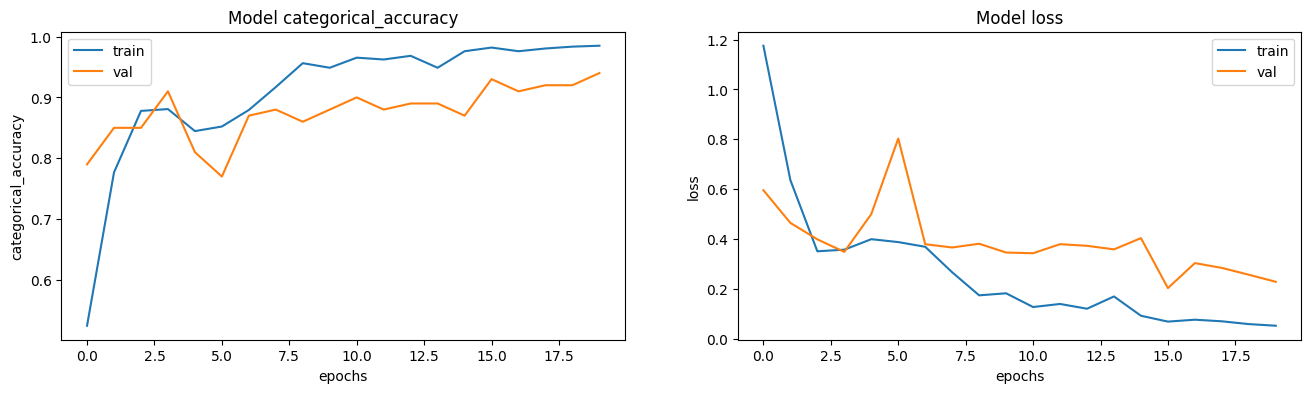

In [45]:
plot_history(history)

#### Observation :: The model seems to be performing well on the training data, but with a small drop in accuracy and an increase in loss on the validation set, which may indicate slight overfitting

In [64]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 16  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
# LTSM
model = create_cnn_rnn_transferlearning_model(dense_nodes=256, dropout=0.25, islstm = 0, transfer_train=False) 
print (model.summary())

# epochs = 20
# batch size = 16
# num_frames per video = 20


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_36             │ (None, 20, 3, 3, 1024) │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 20, 3, 3, 1024) │         4,096 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 20, 1, 1, 1024) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 20, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │       209,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,460,165 (13.20 MB)

 Trainable params: 229,253 (895.52 KB)

 Non-trainable params: 3,230,912 (12.32 MB)

None


In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch2_cnn_rnn_trslrn_3")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [48]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3197 - loss: 1.5576
Epoch 1: val_loss improved from inf to 1.02069, saving model to model_arch2_cnn_rnn_trslrn_3_2024-10-0502_43_29.386650/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 324s 7s/step - categorical_accuracy: 0.3215 - loss: 1.5542 - val_categorical_accuracy: 0.6800 - val_loss: 1.0207 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.6821 - loss: 0.8759
Epoch 2: val_loss improved from 1.02069 to 0.86142, saving model to model_arch2_cnn_rnn_trslrn_3_2024-10-0502_43_29.386650/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - categorical_accuracy: 0.6824 - loss: 0.8746 - val_categorical_accuracy: 0.6700 - val_loss: 0.8614 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.8212 - loss: 0.5185
Epoch 3: val_loss improved from 0.86142 to 0.76740, saving model to model

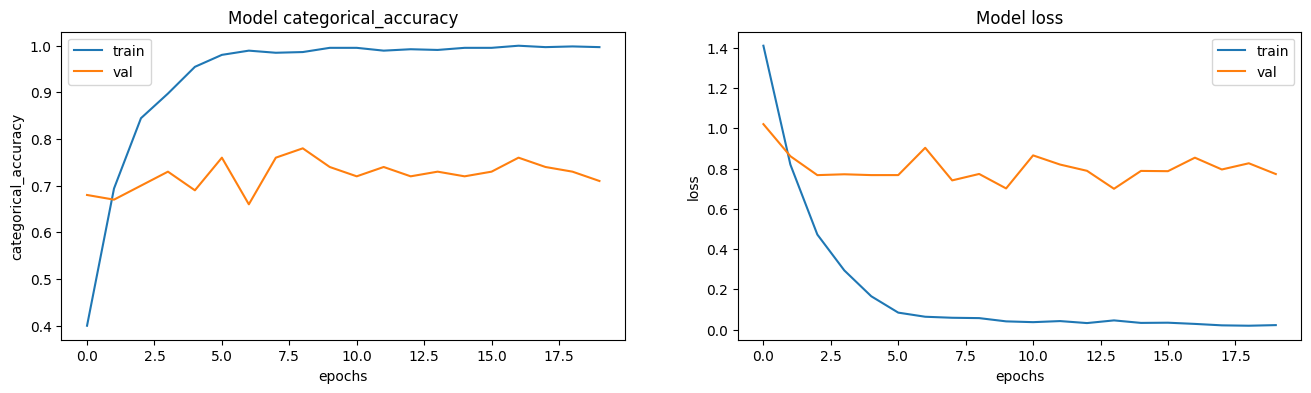

In [49]:
plot_history(history)

#### Observation :: The key observation here is that the training accuracy is much higher than the validation accuracy, and the training loss is significantly lower than the validation loss. This suggests the model might be overfitting the training data

In [72]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 16  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
# GRU
model = create_cnn_rnn_transferlearning_model(dense_nodes=256, dropout=0.25, islstm = 0, transfer_train=True) 
print (model.summary())

# epochs = 20
# batch size = 16
# num_frames per video = 20


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_48             │ (None, 20, 3, 3, 1024) │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_49             │ (None, 20, 3, 3, 1024) │         4,096 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_50             │ (None, 20, 1, 1, 1024) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_51             │ (None, 20, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 64)             │       209,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,460,165 (13.20 MB)

 Trainable params: 3,436,229 (13.11 MB)

 Non-trainable params: 23,936 (93.50 KB)

None


In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch2_cnn_rnn_trslrn_4")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [74]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 416s 7s/step - categorical_accuracy: 0.3952 - loss: 1.3935 - val_categorical_accuracy: 0.8500 - val_loss: 0.4733 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 255s 6s/step - categorical_accuracy: 0.8013 - loss: 0.4886 - val_categorical_accuracy: 0.9000 - val_loss: 0.3209 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 229s 6s/step - categorical_accuracy: 0.9108 - loss: 0.2869 - val_categorical_accuracy: 0.8800 - val_loss: 0.3765 - learning_rate: 0.0010
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - categorical_accuracy: 0.9391 - loss: 0.1938 - val_categorical_accuracy: 0.8900 - val_loss: 0.3946 - learning_rate: 0.0010
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.9000 - loss: 0.2666
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
42/42 ━━━━━━━━━━━━━━━━━━━━ 238s 6s/step - categorical_accuracy: 0.8998 - loss: 0.2673 - val_categorical_accuracy: 0.8400 - val_l

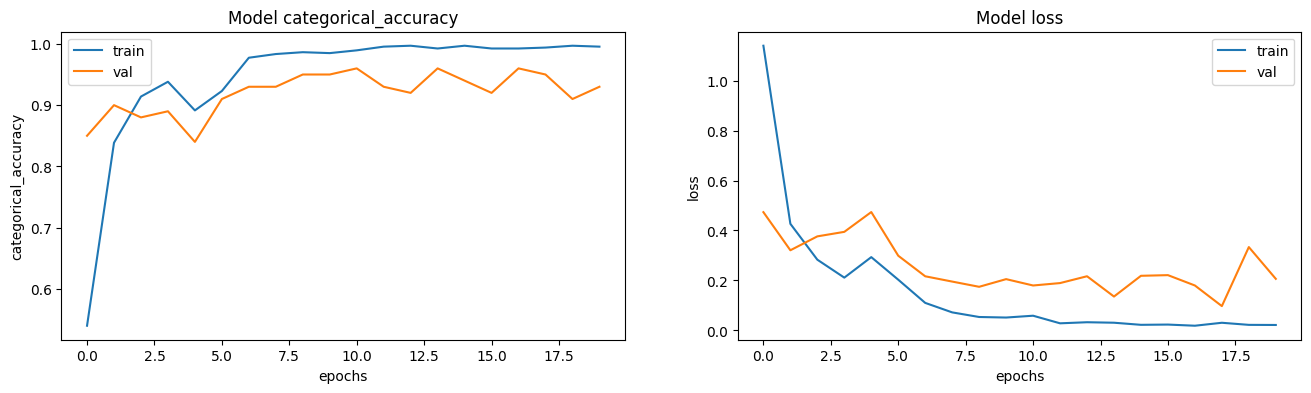

In [75]:
plot_history(history)

#### Observation :: Model has achieved a categorical accuracy of 99.39% and On the validation set, the model achieved 93.00% . The overall training seems to be going well.

### Analysis of all models created in this jupyter notebook
| Architecture | Model Name | Epochs | Batch Size | Sample Frame | Model Parameters | Training Accuracy | Validation Accuracy | Notes |
|------------|------------|--------|-------------|-------------|------------------|-------------------|---------------------|-------|
| Conv3D  | model_arch1_conv3D_1 | 20 | 64 | 30 | Total params: 1,933,765 (7.38 MB) <br> Trainable params: 1,932,517 (7.37 MB) <br> Non-trainable params: 1,248 (4.88 KB) | 100 | 19| |
| Conv3D  | model_arch1_conv3D_2 | 20 | 32 | 20 | Total params: 1,933,765 (7.38 MB) <br> Trainable params: 1,932,517 (7.37 MB) <br> Non-trainable params: 1,248 (4.88 KB) | 99 | 33| |
| Conv3D  | model_arch1_conv3D_3 | 20 | 8 | 20 | Total params: 1,933,765 (7.38 MB) <br> Trainable params: 1,932,517 (7.37 MB) <br> Non-trainable params: 1,248 (4.88 KB) | 93 | 84| |
| Conv3D  | model_arch1_conv3D_4 | 20 | 16 | 20 | Total params: 4,446,853 (16.96 MB) <br> Trainable params: 4,444,869 (16.96 MB) <br> Non-trainable params: 1,984 (7.75 KB) | 91 | 88| |
| CNN + RNN with LTSM | model_arch2_cnn_rnn_1 | 20 | 64 | 30 | Total params: 1,052,773 (4.02 MB) <br> Trainable params: 1,051,013 (4.01 MB) <br> Non-trainable params: 1,760 (6.88 KB)  |  |  | ##### OOM Error got triggered as GPU is running out of memory.
| CNN + RNN with LTSM | model_arch2_cnn_rnn_2 | 20 | 16 | 30 | Total params: 1,052,773 (4.02 MB) <br> Trainable params: 1,051,013 (4.01 MB) <br> Non-trainable params: 1,760 (6.88 KB) | 91 | 71 | 
| CNN + RNN with LTSM | model_arch2_cnn_rnn_3 | 20 | 16 | 20 | Total params: 1,052,773 (4.02 MB) <br> Trainable params: 1,051,013 (4.01 MB) <br> Non-trainable params: 1,760 (6.88 KB) | 66 | 60 | 
| CNN + RNN with GRU | model_arch2_cnn_rnn_4 | 20 | 16 | 20 | Total params: 901,349 (3.44 MB) <br> Trainable params: 899,589 (3.43 MB) <br> Non-trainable params: 1,760 (6.88 KB) | 88 | 77 | 
| Transfer Learning using MobileNet + LTSM  <br> + Training of Internal layers set to False | model_arch2_cnn_rnn_trslrn_1 | 20 | 16 | 20 | Total params: 3,529,669 (13.46 MB) <br> Trainable params: 298,757 (1.14 MB) <br> Non-trainable params: 3,230,912 (12.32 MB) | 99 | 79 | 
| Transfer Learning using MobileNet + LTSM  <br> + Training of Internal layers set to True | model_arch2_cnn_rnn_trslrn_2 | 20 | 16 | 20 | Total params: 3,529,669 (13.46 MB) <br> Trainable params: 3,505,733 (13.37 MB) <br> Non-trainable params: 23,936 (93.50 KB) | 97 | 94 | 
| Transfer Learning using MobileNet + GRU  <br> + Training of Internal layers set to False | model_arch2_cnn_rnn_trslrn_3 | 20 | 16 | 20 | Total params: 3,460,165 (13.20 MB) <br> Trainable params: 229,253 (895.52 KB) <br> Non-trainable params: 3,230,912 (12.32 MB) | 99 | 71 | 
| Transfer Learning using MobileNet + GRU  <br> + Training of Internal layers set to True | model_arch2_cnn_rnn_trslrn_4 | 20 | 16 | 20 | Total params: 3,460,165 (13.20 MB)  <br> Trainable params: 3,436,229 (13.11 MB)  <br> Non-trainable params: 23,936 (93.97 KB)Based on the scores choosen this model | 99 | 93  | This wil be our final model



### Load Selected Model
Loading the selected model from the disk 

In [76]:
from keras.models import load_model
model = load_model('model_arch2_cnn_rnn_trslrn_4_2024-10-0502_43_29.386650/best_model_weightdetails.weights.keras')

In [77]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 16  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
# GRU
test_generator = create_cnn_rnn_transferlearning_model(dense_nodes=256, dropout=0.25, islstm = 0, transfer_train=True) 

# epochs = 20
# batch size = 16
# num_frames per video = 20


In [78]:
test_generator.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_52             │ (None, 20, 3, 3, 1024) │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_53             │ (None, 20, 3, 3, 1024) │         4,096 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_54             │ (None, 20, 1, 1, 1024) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_55             │ (None, 20, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 64)             │       209,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,460,165 (13.20 MB)

 Trainable params: 3,436,229 (13.11 MB)

 Non-trainable params: 23,936 (93.50 KB)